<a href="https://colab.research.google.com/github/AmishiR/ML-Lab/blob/main/Lab_05_Multiclass_Classification_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Lab-05: Multiclass Classification with Logistic Regression (Handwritten Digits)

# Introduction

In this lab, we explore **multiclass classification** using one of the simplest yet powerful models in machine learning — **Logistic Regression**.  
Although logistic regression is originally designed for **binary classification**, it can be extended to handle multiple classes through strategies such as **One-vs-All (OvA)** and **Softmax Regression**.

We will work with the **Handwritten Digits dataset** from scikit-learn, which contains **8×8 grayscale images** of digits (0–9).  
**Dataset:** `sklearn.datasets.load_digits` (8×8 grayscale images of digits 0–9).  
This dataset provides a perfect playground to understand how Logistic Regression can be scaled up from classifying two categories (e.g., “cat vs. non-cat”) to handling **ten digit classes**.

Throughout the lab, we will:

- Train models using both:
  - `LogisticRegression` (with OvA and Softmax options), and  
  - `SGDClassifier(loss="log_loss")` (stochastic gradient descent version).  
- Evaluate the models using **confusion matrices**, **classification reports**, **ROC curves**, and **AUC scores**.  
- Study the impact of **regularization strength (C)** on performance.  
- Perform **error analysis** to see which digits are commonly misclassified and why.  
- Experiment with different solvers for optimiztion.  


By the end of this lab, you should not only understand how logistic regression works for multiclass problems, but also gain practical skills in **model evaluation, tuning, and interpretation**.


**Learning outcomes**
- Understand binary logistic regression and its extension to multiclass (One-vs-All and Softmax).
- Train models using both **`LogisticRegression`** and **`SGDClassifier(loss="log_loss")`**.
- Interpret **confusion matrices**, **classification reports**, **ROC curves**, and **AUC** for multiclass classification.
- Practice **regularization** and basic **hyperparameter tuning**.



## 1. Theory Primer

### 1.1 Binary Logistic Regression
Given an input vector $x \in \mathbb{R}^d$ (optionally with a bias term), logistic regression models
the probability of class $y \in \{0,1\}$ as
$
h_\theta(x)=\sigma(\theta^\top x)=\frac{1}{1+\exp(-\theta^\top x)}.
$
The decision rule is $\hat{y}=\mathbb{1}$ if $[h_\theta(x)\ge 0.5]$.

**Loss (negative log-likelihood / cross-entropy)** over $m$ examples:
$
J(\theta)= -\frac{1}{m}\sum_{i=1}^m \left[y^{(i)}\log h_\theta(x^{(i)}) + (1-y^{(i)})\log\big(1-h_\theta(x^{(i)})\big)\right].
$

**L2-regularization** (As emphasized in theory class, it is used to reduce overfitting):
$
J_\lambda(\theta)=J(\theta)+\frac{\lambda}{2m}\lVert\theta\rVert_2^2.
$

**Gradient**:
$
\nabla_\theta J_\lambda(\theta)=\frac{1}{m}X^\top\!\big(h_\theta(X)-y\big)+\frac{\lambda}{m}\theta,
$
where $X \in \mathbb{R}^{m\times d}$ is the design matrix.



### 1.2 Multiclass Extensions

**One-vs-All (OvA / One-vs-Rest):** Train $K$ binary logistic classifiers; the $k$-th classifier predicts $p(y=k\mid x;\theta_k)$ vs. the rest. At test time, pick the class with the largest score/probability. This is the approach we used for vanilla logistic regression.

**Softmax (Multinomial Logistic Regression):** Learn a weight vector $\theta_k$ per class $k=1$,$\dots$,$K$. The class probabilities are
$
p(y=k\mid x;\theta_k)=\frac{\exp(\theta_k^\top x)}{\sum_{j=1}^K \exp(\theta_j^\top x)}.
$

**Loss (cross-entropy)**:
$
J(\Theta)=-\frac{1}{m}\sum_{i=1}^m \sum_{k=1}^K \mathbb{1}[y^{(i)}=k]\log p(y^{(i)}=k\mid x^{(i)})
\quad +\quad \frac{\lambda}{2m}\sum_{k=1}^K \lVert\theta_k\rVert_2^2.
$
Both OvA and Softmax work well; Softmax is a single joint optimization and often gives slightly better calibrated probabilities.



### 1.3 Evaluation Metrics (per-class and aggregated)

- **Confusion Matrix** $C_{ij}$: true class $i$, predicted class $j$.
- **Precision** $= \frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FP}}$, **Recall** $= \frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}$, **F1** $= \frac{2 \cdot \mathrm{Precision}\cdot \mathrm{Recall}}{\mathrm{Precision}+\mathrm{Recall}}$.
- **Macro** averages: unweighted mean across classes (treats all classes equally).  
- **Weighted** averages: weighted by class support (useful under imbalance).  
- **ROC & AUC (One-vs-Rest):** For each class $k$, treat $k$ as positive and others as negative, compute ROC curve $\mathrm{TPR}(\mathrm{FPR})$; the **AUC** summarizes performance.



## 2. Setup & Data


In [ ]:
# Import Libararies
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score,
    roc_curve, auc, RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from time import time

# Ensure plots render inline (for Jupyter)
%matplotlib inline

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
# Load Handwritten Digit dataset
digits = load_digits()
X, y = digits.data, digits.target
images = digits.images  # shape (n_samples, 8, 8)

print('Features shape:', X.shape)
print('Targets shape :', y.shape)
print('Classes       :', np.unique(y))


Features shape: (1797, 64)
Targets shape : (1797,)
Classes       : [0 1 2 3 4 5 6 7 8 9]


In [ ]:
type(digits)

sklearn.utils._bunch.Bunch

In [ ]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

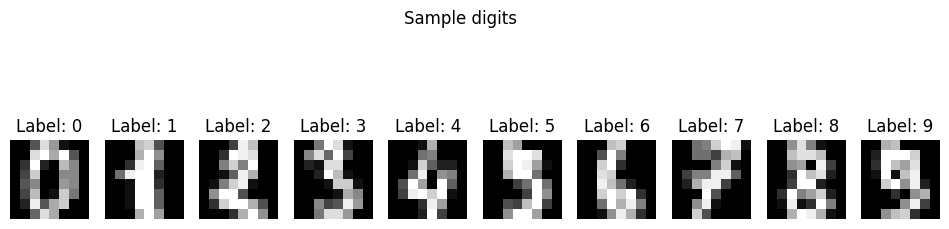

In [ ]:
# Peek at a few samples
n_show = 10
fig, axes = plt.subplots(1, n_show, figsize=(12, 3.5))
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')
plt.suptitle('Sample digits')
plt.show()


In [ ]:
# Train/test split (stratified to preserve class proportions)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=RANDOM_STATE )

print('Train size:', X_train.shape[0], ' Test size:', X_test.shape[0])


Train size: 1437  Test size: 360



## 3. Logistic Regression (One-vs-Rest by default)
The scikit-learn default with `multi_class='ovr'` trains one classifier per class. Increase `max_iter` to ensure convergence.


In [ ]:


lr_ovr=OneVsRestClassifier(LogisticRegression(max_iter=5000, solver='lbfgs', random_state=RANDOM_STATE))
t0 = time()
lr_ovr.fit(X_train, y_train)
t1 = time()
y_pred_lr=lr_ovr.predict( X_test)


print(f'LR (OvR) accuracy: {accuracy_score(y_test, y_pred_lr):.4f}  | Train time: {t1-t0:.3f}s')
print('\nClassification report (LR OvR):\n')
print(classification_report(y_test, y_pred_lr))


LR (OvR) accuracy: 0.9583  | Train time: 0.756s

Classification report (LR OvR):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.97      0.83      0.90        36
           2       1.00      0.97      0.99        35
           3       0.92      0.97      0.95        37
           4       0.97      1.00      0.99        36
           5       0.97      0.97      0.97        37
           6       0.97      0.97      0.97        36
           7       0.95      0.97      0.96        36
           8       0.85      0.97      0.91        35
           9       1.00      0.92      0.96        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



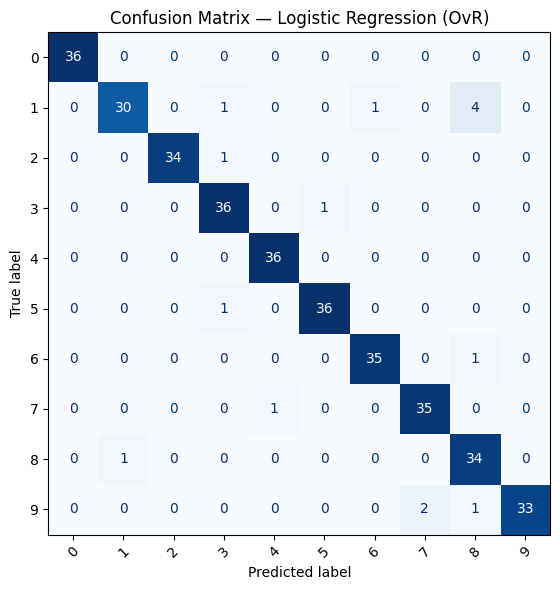

In [ ]:
# Confusion matrix
cm_lr=confusion_matrix(y_test,y_pred_lr,labels=np.unique(y))
disp=ConfusionMatrixDisplay(confusion_matrix=cm_lr,display_labels=np.unique(y))


fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix — Logistic Regression (OvR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


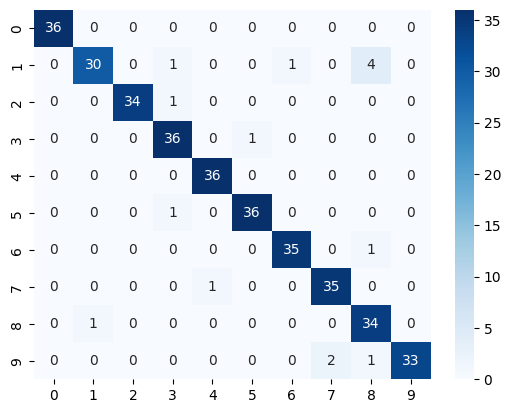

In [ ]:
import seaborn as sns
sns.heatmap(cm_lr,annot=True,fmt='d',cmap='Blues')
plt.show()


## 4. SGD Logistic Regression
Stochastic Gradient Descent with `loss="log_loss"` approximates the logistic regression solution using minibatches/online updates. This is closer to the optimization techniques you learn in theory class (gradient descent variants).


In [ ]:
sgd_log=SGDClassifier(loss="log_loss", max_iter=2000, tol=1e-3,random_state=RANDOM_STATE)
t0 = time()
sgd_log.fit(X_train, y_train)
t1=time()
y_pred_sgd=sgd_log.predict(X_test)



print(f'SGD-Logistic accuracy: {accuracy_score(y_test, y_pred_sgd):.4f}  | Train time: {t1-t0:.3f}s')
print('\nClassification report (SGD Logistic):\n')
print(classification_report(y_test, y_pred_sgd))


SGD-Logistic accuracy: 0.9611  | Train time: 0.079s

Classification report (SGD Logistic):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.94      0.83      0.88        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       0.97      1.00      0.99        36
           5       0.97      1.00      0.99        37
           6       0.97      0.97      0.97        36
           7       0.92      0.97      0.95        36
           8       0.86      0.91      0.89        35
           9       0.97      0.92      0.94        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



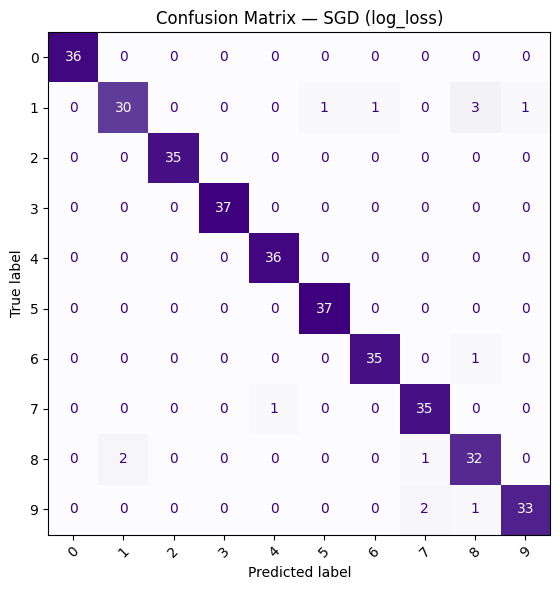

In [ ]:
# Confusion matrix for SGD model
cm_sgd=confusion_matrix(y_test,y_pred_sgd,labels=np.unique(y))
disp=ConfusionMatrixDisplay(confusion_matrix=cm_sgd,display_labels=np.unique(y))


fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap='Purples', colorbar=False)
plt.title('Confusion Matrix — SGD (log_loss)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


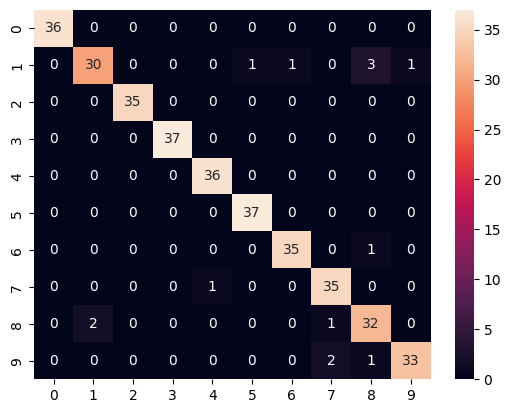

In [ ]:
import seaborn as sns
sns.heatmap(cm_sgd,annot=True,fmt='d')
plt.show()


## 5. Multiclass ROC & AUC (One-vs-Rest)

For each class $k$, treat it as positive and the rest as negative. Plot the ROC curve using the decision scores/probabilities from the model. We also show **micro** and **macro** averages for a single summary curve.


## 🔎 Understanding `label_binarize`

When working with **ROC curves**, the inputs must be **binary labels** (0/1).  
However, in **multiclass classification**, the labels are categorical (e.g., `0, 1, 2`).  
To handle this, we use **`label_binarize`** from `sklearn.preprocessing`.

---

### ✅ What does `label_binarize` do?

It converts categorical labels into a **binary indicator matrix**.

- Each **row** = one sample  
- Each **column** = one class  
- A `1` indicates the class that the sample belongs to  

---

### 📊 Example 1: Binary case

```python
from sklearn.preprocessing import label_binarize

y = [0, 1, 0, 1, 1]
Y_bin = label_binarize(y, classes=[0, 1])
print(Y_bin)
```
### 📊 Example 2: Multiclass case

```python
from sklearn.preprocessing import label_binarize
y = [0, 2, 1, 2, 0]
Y_bin = label_binarize(y, classes=[0, 1, 2])
print(Y_bin)
```

In [ ]:
from sklearn.preprocessing import label_binarize
y = [0, 2, 1, 2, 0]
Y_bin = label_binarize(y, classes=[0, 1, 2])
print(Y_bin)

[[1 0 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [1 0 0]]


In [ ]:
# One-vs-rest ROC for Logistic Regression (use decision_function if available; otherwise predict_proba)
from itertools import cycle

classes = np.unique(y)
Y_test_bin = label_binarize(y_test, classes=classes)

# Scores: use decision_function if present; else use predict_proba
if hasattr(lr_ovr, "decision_function"):
    scores = lr_ovr.decision_function(X_test)
else:
    scores = lr_ovr.predict_proba(X_test)

# Compute per-class ROC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i, k in enumerate(classes):
    fpr[k], tpr[k], _ = roc_curve(Y_test_bin[:, i], scores[:, i])
    roc_auc[k] = auc(fpr[k], tpr[k])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
# Aggregate all FPRs
all_fpr = np.unique(np.concatenate([fpr[k] for k in classes]))
# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for k in classes:
    mean_tpr += np.interp(all_fpr, fpr[k], tpr[k])
mean_tpr /= len(classes)
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot
plt.figure(figsize=(9,7))
plt.plot(fpr["micro"], tpr["micro"], linestyle='--', label=f'micro-average ROC (AUC={roc_auc["micro"]:.3f})')
plt.plot(fpr["macro"], tpr["macro"], linestyle='--', label=f'macro-average ROC (AUC={roc_auc["macro"]:.3f})')

# Plot a subset of class curves to avoid clutter; show all if you prefer
for k in classes:
    plt.plot(fpr[k], tpr[k], label=f'class {k} (AUC={roc_auc[k]:.2f})')

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC — Logistic Regression (OvR)')
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [1080, 3600]

## 6. Error Analysis: What does the model confuse?
Visualize a few misclassified examples to build intuition (Targeted error analysis).


# of misclassified by LR OvR: 15


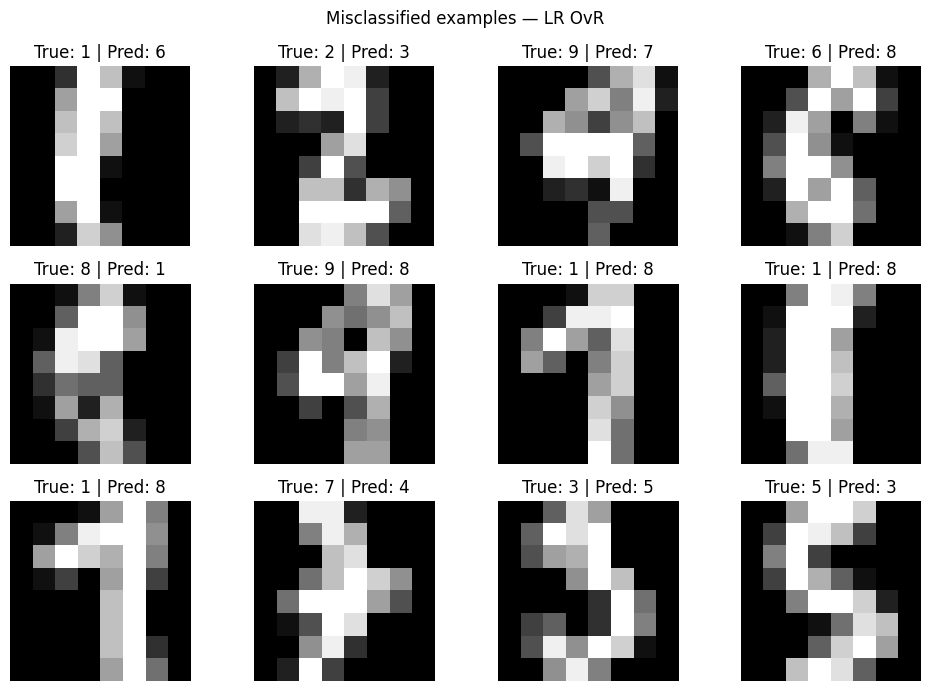

In [ ]:

mis_idx = np.where(y_test != y_pred_lr)[0]
print(f'# of misclassified by LR OvR: {len(mis_idx)}')

n_show = min(12, len(mis_idx))
fig, axes = plt.subplots(3, 4, figsize=(10, 7))
axes = axes.ravel()
for i in range(n_show):
    idx = mis_idx[i]
    axes[i].imshow(X_test[idx].reshape(8,8), cmap='gray')
    axes[i].set_title(f"True: {y_test[idx]} | Pred: {y_pred_lr[idx]}")
    axes[i].axis('off')
plt.suptitle('Misclassified examples — LR OvR')
plt.tight_layout()
plt.show()



## 7. Hyperparameter Tuning: Regularization strength $C$

Scikit-learn uses $C = 1/\lambda$ convention. Smaller $C$ ⇒ stronger regularization (more bias, less variance). Explore the accuracy vs $C$.


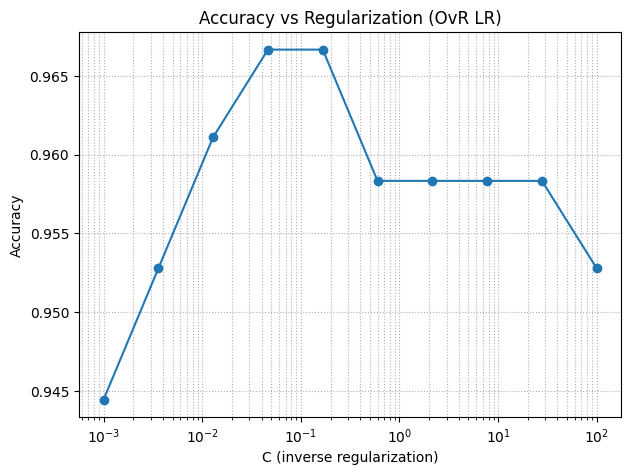

In [ ]:

Cs = np.logspace(-3, 2, 10)
accs = []
for C in Cs:

    clf = OneVsRestClassifier(LogisticRegression(C=C, max_iter=3000, solver='lbfgs', random_state=RANDOM_STATE))
    clf.fit(X_train, y_train)
    accs.append(accuracy_score(y_test, clf.predict(X_test)))

plt.figure(figsize=(7,5))
plt.semilogx(Cs, accs, marker='o')
plt.xlabel('C (inverse regularization)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Regularization (OvR LR)')
plt.grid(True, which='both', ls=':')
plt.show()



## 8. Extensions (Optional)

### 8.1 Multinomial Logistic Regression (Softmax)
`LogisticRegression(multi_class="multinomial", solver="lbfgs" or "saga")` trains a joint softmax model.


In [ ]:
# Multinomial (Softmax) vs OvR
lr_softmax = LogisticRegression(max_iter=5000, solver='lbfgs',  random_state=RANDOM_STATE)
t0 = time()
lr_softmax.fit(X_train, y_train)
t1 = time()
y_pred_soft = lr_softmax.predict(X_test)
print(f'LR (Softmax) accuracy: {accuracy_score(y_test, y_pred_soft):.4f}  | Train time: {t1-t0:.3f}s')
print('\nClassification report (LR Softmax):\n')
print(classification_report(y_test, y_pred_soft))


LR (Softmax) accuracy: 0.9583  | Train time: 2.477s

Classification report (LR Softmax):

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.89      0.89      0.89        36
           2       0.97      1.00      0.99        35
           3       0.95      1.00      0.97        37
           4       0.95      1.00      0.97        36
           5       0.97      0.97      0.97        37
           6       1.00      0.97      0.99        36
           7       1.00      0.97      0.99        36
           8       0.86      0.86      0.86        35
           9       1.00      0.94      0.97        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360




## 9. Homework Exercises (Submit short answers + code)

1. **Imbalance Thought Experiment:** Create an artificial imbalance by downsampling digits {1, 2, 3}. Compare **accuracy**, **macro-F1**, and **weighted-F1**. Which metric is most informative? Why?
2. **Regularization & Over/Underfitting:** Sweep \(C\) over a wide range (e.g., \(10^{-4}\) to \(10^{3}\)). Plot train vs test accuracy. Identify the region of underfitting and overfitting.
3. **Solver Comparison:** Compare `lbfgs`, `saga`, and `newton-cg` (where supported). Track train time and accuracy. Which scales better? Any difference between OvR and multinomial?
4. **Calibration (Bonus):** Use `CalibratedClassifierCV` on the SGD model. Visualize reliability diagrams (calibration plots). Comment on probability calibration.
5. **Error Analysis:** For the 20 most confident *wrong* predictions (use `predict_proba` or decision scores), display the images with predicted probability and true label. What patterns do you see?
6. **Binary AUC Focus:** Train a binary classifier for digits **3 vs 8** only. Plot ROC and compute AUC. Compare with their OvR curves in the multiclass setting.
7. **Feature Scaling (Bonus):** Apply `StandardScaler` and re-train SGD. How does it affect convergence and performance?



## 10. References & Notes
- CLass Hanouts on **Logistic Regression**, **Regularization**, **Softmax Regression (Multinomial LR)**, and **Evaluation/Error Analysis**.
- scikit-learn documentation for `LogisticRegression`, `SGDClassifier`, and metrics.
- ROC/AUC methodology via One-vs-Rest as commonly practiced for multiclass evaluation.



## Appendix: Useful Derivations

**Binary Cross-Entropy Gradient:** With $X\in\mathbb{R}^{m\\times d}$, $y\in\{0,1\}^m$, predictions $\hat{y}=\sigma(X\theta)$:
$
\nabla_\theta J(\theta)=\frac{1}{m}X^\top(\\hat{y}-y).
$

**SGD Update (per example $(x^{(i)},y^{(i)})$)** with learning rate $\eta$:
$
\theta \leftarrow \theta - \eta\left[(\sigma(\theta^\top x^{(i)})-y^{(i)})x^{(i)} + \frac{\\lambda}{m}\theta\right].
$

**Softmax Gradient** (for class \(k\)) with one-hot \(y\):
$
\nabla_{\theta_k} J(\Theta)=\frac{1}{m} \sum_{i=1}^m \big(p_k^{(i)}-\mathbb{1}[y^{(i)}=k]\big) x^{(i)} + \frac{\lambda}{m}\theta_k,
$
where $p_k^{(i)}=\frac{\exp(\theta_k^\top x^{(i)})}{\sum_j \exp(\theta_j^\top x^{(i)})}$.
